In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import pathlib
import shutil
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
from sklearn import metrics

['resnet152', 'dogs-vs-cats-redux-kernels-edition']


In [6]:

from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [7]:
PATH="../input/dogs-vs-cats-redux-kernels-edition"

In [8]:
os.makedirs(f'../working/train/dog', exist_ok=True)
os.makedirs(f'../working/train/cat', exist_ok=True)
os.makedirs(f'../working/valid/dog', exist_ok=True)
os.makedirs(f'../working/valid/cat', exist_ok=True)
os.makedirs(f'../working/test', exist_ok=True)

In [9]:
filenames = os.listdir(f'{PATH}/train')

In [10]:
dog_indexes = []
cat_indexes = []

for fn in filenames:
    if 'dog' in fn:
        dog_indexes.append(fn.split('.')[1])
    else:
        cat_indexes.append(fn.split('.')[1])
        
print(len(dog_indexes), len(cat_indexes))

12500 12500


Get Validation set

In [11]:
val_dog_indexes = random.sample(dog_indexes, int(len(dog_indexes) * 0.2))
val_cat_indexes = random.sample(cat_indexes, int(len(cat_indexes) * 0.2))
print(len(val_dog_indexes), len(val_cat_indexes))

2500 2500


In [12]:
for fn in filenames:
    if 'dog' in fn:
        dog_id = fn.split('.')[1]
        if dog_id in val_dog_indexes:
            shutil.copy(f'{PATH}/train/{fn}', f'../working/valid/dog')
        else:
            shutil.copy(f'{PATH}/train/{fn}', f'../working/train/dog')
    if 'cat' in fn:
        cat_id = fn.split('.')[1]
        if cat_id in val_cat_indexes:
            shutil.copy(f'{PATH}/train/{fn}', f'../working/valid/cat')
        else:
            shutil.copy(f'{PATH}/train/{fn}', f'../working/train/cat')

In [13]:
for fn in os.listdir(f'{PATH}/test'):
    shutil.copy(f'{PATH}/test/{fn}', f'../working/test')

In [14]:
PATH = '../working'
print(len(os.listdir(f'{PATH}/train/cat')))
print(len(os.listdir(f'{PATH}/train/dog')))
print(len(os.listdir(f'{PATH}/valid/cat')))
print(len(os.listdir(f'{PATH}/valid/dog')))

10000
10000
2500
2500


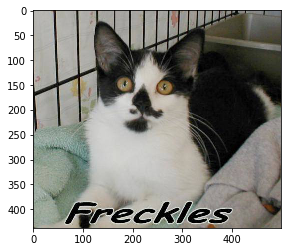

In [15]:
cat_filenames = os.listdir(f'{PATH}/train/cat')
sample_image = plt.imread(f'{PATH}/train/cat/{cat_filenames[0]}')
plt.imshow(sample_image)

In [16]:
sample_image.shape

(438, 499, 3)

In [17]:
filename_size_map = {fn: PIL.Image.open(f'{PATH}/train/cat/{fn}').size for fn in cat_filenames}

In [18]:
rows, cols = zip(*filename_size_map.values())

(array([ 178.,  846., 1627., 1928., 5420.,    0.,    0.,    0.,    0.,    1.]),
 array([  50. ,  147.3,  244.6,  341.9,  439.2,  536.5,  633.8,  731.1,  828.4,  925.7, 1023. ]),
 <a list of 10 Patch objects>)

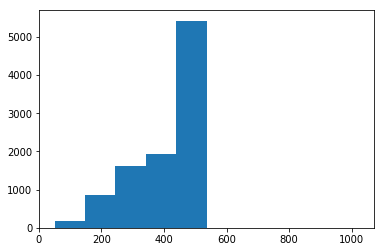

In [19]:
plt.hist(rows)

(array([  84.,  438., 1115., 1324., 4398., 1003., 1637.,    0.,    0.,    1.]),
 array([ 32. , 105.6, 179.2, 252.8, 326.4, 400. , 473.6, 547.2, 620.8, 694.4, 768. ]),
 <a list of 10 Patch objects>)

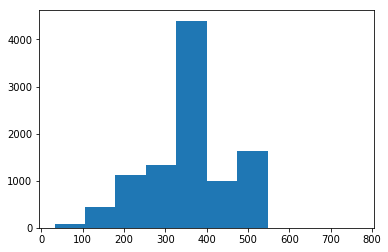

In [20]:
plt.hist(cols)

In [21]:
arch = resnet152

In [44]:
def get_data(img_size, batch_size):
    tfms = tfms_from_model(arch, img_size, transforms_side_on, 1.1)
    return ImageClassifierData.from_paths(f'{PATH}/', batch_size, tfms, test_name='test')

In [45]:
data = get_data(224, 64)
data.path = pathlib.Path('.')
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [24]:
learn.lr_find()

 89%|████████▉ | 278/313 [05:28<00:41,  1.18s/it, loss=0.295] 

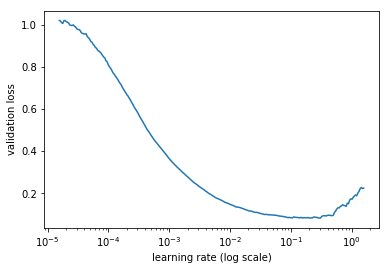

In [25]:
learn.sched.plot()

In [26]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.030516   0.020471   0.9932    
    1      0.036814   0.015344   0.994                        
    2      0.029334   0.015519   0.9942                       
    3      0.027771   0.015324   0.994                        
    4      0.032087   0.014992   0.9946                       
    5      0.026309   0.015474   0.9944                       
    6      0.019934   0.015356   0.9946                       


[0.015356345748901367, 0.9946]

In [27]:
learn.save('last_layer_226')

In [46]:
learn.load('last_layer_226')

In [47]:
log_prob, y = learn.TTA(is_test=True)
prob = np.mean(np.exp(log_prob), 0)

In [76]:
df = pd.DataFrame(prob[:, 1])
submit_df = df.rename(columns = {0:'label'})
submit_df.head()
submit_df.size

12500

In [77]:
submit_df.insert(0, 'id', [fn[:-4] for fn in os.listdir(f'{PATH}/test')])
submit_df.head()

,id,label
0,902,0.000724
1,2736,0.000026
2,1984,0.999773
3,1713,0.000076
4,2807,0.000104


In [81]:
SUBMIT_PATH = './submit'
os.makedirs(SUBMIT_PATH, exist_ok=True)
submit_df.to_csv(f'{SUBMIT_PATH}/submit.gz', compression='gzip', index=False)

In [82]:
FileLink(f'{SUBMIT_PATH}/submit.gz')

/kaggle/working/submit/submit.gz